,dd,captured,population,active_0,active_1,active_2,eggs_1,eggs_2
76,76,0.000616,1.491998,1.491383,0.0,0,1000.0,0.0
96,96,1.013571,682.922591,681.909020,0.0,0,1000.0,0.0


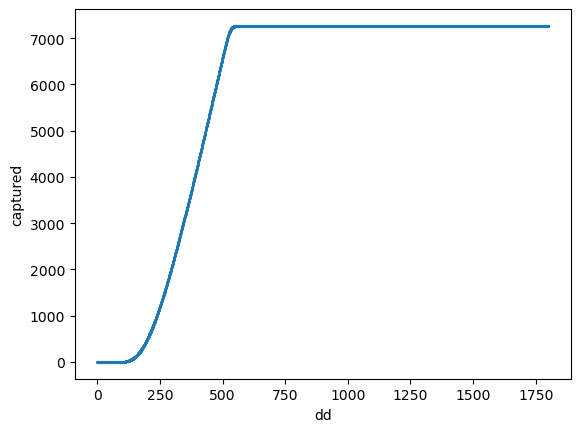

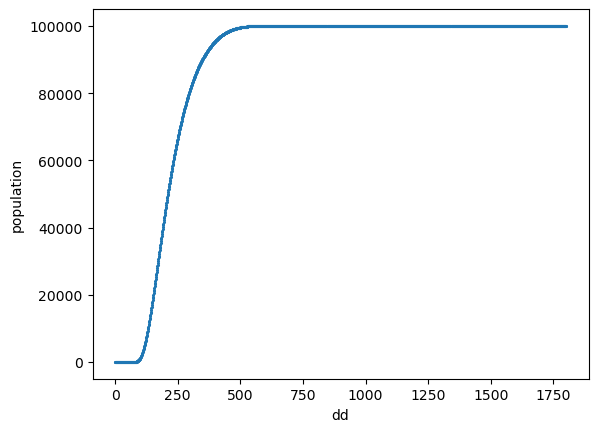

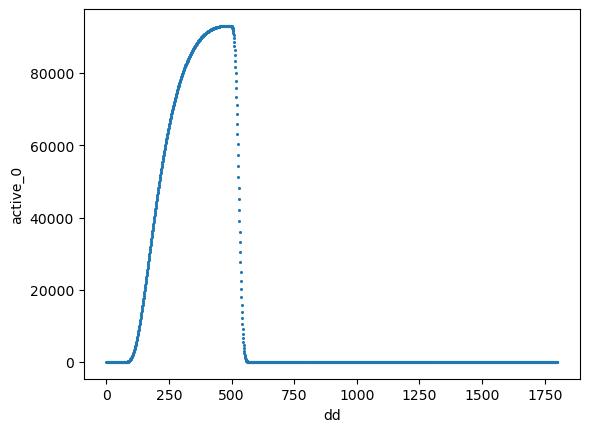

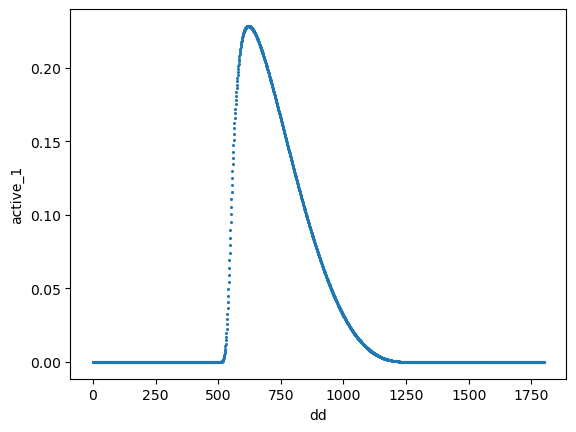

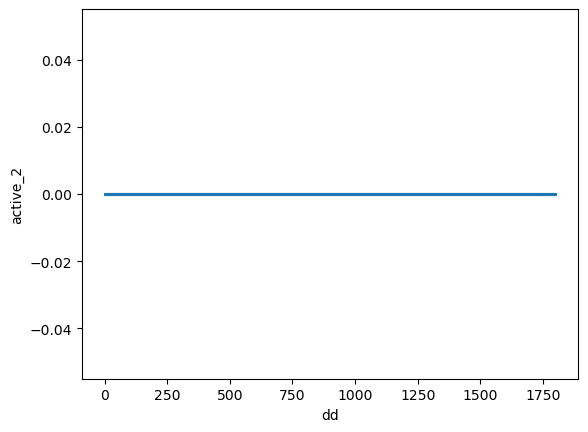

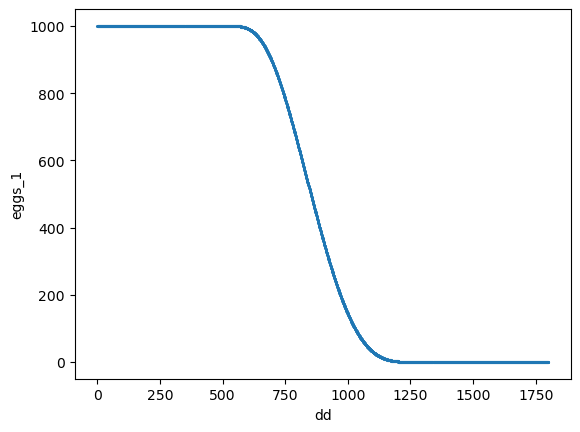

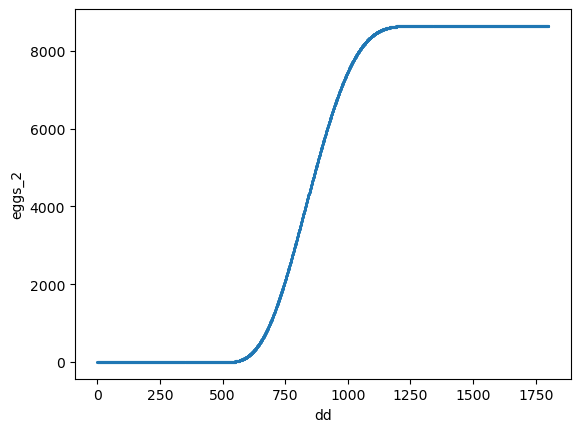

In [1]:
import pandas as pd
df = pd.read_csv('test_0.csv')
df.plot.scatter(0, 1, 1.5)
df.plot.scatter(0, 2, 1.5)
df.plot.scatter(0, 3, 1.5)
df.plot.scatter(0, 4, 1.5)
df.plot.scatter(0, 5, 1.5)
df.plot.scatter(0, 6, 1.5)
df.plot.scatter(0, 7, 1.5)
pd.concat([df[df.population >= 1].head(1), df[df.captured >= 1].head(1)])

In [2]:
(1 - (df.tail(1).eggs_1 / df.eggs_1.max()))

1800    1.0
Name: eggs_1, dtype: float64

In [3]:
df.eggs_1.max()

1000.0

In [4]:
df.tail(1).eggs_1

1800    6.290000e-14
Name: eggs_1, dtype: float64

In [5]:
df.tail(1)

,dd,captured,population,active_0,active_1,active_2,eggs_1,eggs_2
1800,1800,7265.731957,100000.000003,0.0,0.0,0,6.290000e-14,8637.899559
